#### A quick recap of what's done on MLP part of the modelling

In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
!wget https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt

--2023-05-14 21:25:41--  https://raw.githubusercontent.com/suvigyajain0101/NLP/llms/LLMs/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-05-14 21:25:41 (13.2 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [50]:
words = open('names.txt').read().splitlines()
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [51]:
len(words)

32033

In [52]:
# Build vocab of characters and mapping to and from integers
chars = sorted(list(set(''.join(words))))
assert len(chars) == 26

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

print(stoi)
print(itos)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [53]:
import random

block_size = 3

def build_dataset(words):
  
  X, Y = [], []

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

# Random shuffle of words
random.seed(42)
random.shuffle(words)
# Training data -> 80%, Val data -> 10%, testing data -> 10%
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print('Training Data Size: ', len(X_train))
print('Validation Data Size: ', len(X_val))
print('Testing Data Size: ', len(X_test))

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
Training Data Size:  182625
Validation Data Size:  22655
Testing Data Size:  22866


In [54]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

Total trainable parameters:  11897


In [55]:
batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

Epoch 0 -> Loss = 23.228981018066406 
Epoch 10000 -> Loss = 2.3552074432373047 
Epoch 20000 -> Loss = 2.557803153991699 
Epoch 30000 -> Loss = 2.9109957218170166 
Epoch 40000 -> Loss = 2.601905345916748 
Epoch 50000 -> Loss = 2.3235671520233154 
Epoch 60000 -> Loss = 2.2421650886535645 
Epoch 70000 -> Loss = 2.357235908508301 
Epoch 80000 -> Loss = 2.453921318054199 
Epoch 90000 -> Loss = 2.024482250213623 
Epoch 100000 -> Loss = 1.9406325817108154 
Epoch 110000 -> Loss = 2.067153215408325 
Epoch 120000 -> Loss = 2.1854145526885986 
Epoch 130000 -> Loss = 2.1362953186035156 
Epoch 140000 -> Loss = 1.6812721490859985 
Epoch 150000 -> Loss = 2.35681414604187 
Epoch 160000 -> Loss = 2.1064600944519043 
Epoch 170000 -> Loss = 2.105149507522583 
Epoch 180000 -> Loss = 2.249282121658325 
Epoch 190000 -> Loss = 2.048095226287842 


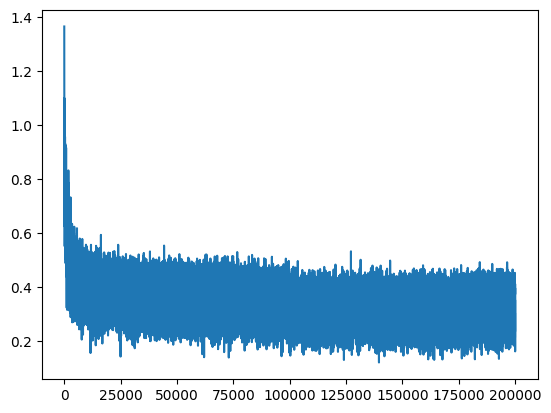

In [56]:
plt.plot(lossi)

In [57]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
  '''Function returns split level loss'''
  x, y = {
      'train': (X_train, Y_train),
      'val': (X_val, Y_val),
      'test': (X_test, Y_test)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)

  h0 = embcat @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1127216815948486
val 2.151665687561035


In [58]:
g = torch.Generator().manual_seed(10)

for _ in range(20):

  out = []
  context = [0]*block_size

  while True:
    emb = C[torch.tensor([context])]
    h0 = emb.view(1, -1) @ W1 + b1
    h = torch.tanh(h0)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim=1)

    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]

    out.append(itos[ix])

    if ix == 0:
      break
      
  print(''.join(out))

pro.
ehiz.
eliyan.
nan.
tomrica.
coptis.
azylin.
danajuel.
cimbaebriellis.
rayta.
avara.
areolynn.
austhan.
arius.
thika.
nas.
massanna.
jahensietta.
jaysylyni.
zaida.


The neural network architecture and functionality defined above has few issues which can (and are) impacting the performance and quality of the names generated - 


#### Issue 1

Intial loss of the model is very high. For a naive model, this should be close to 3.2 - Negative log of probability, which is 1/27. This has to do with the random initialization. Initial values are so far off the reality (or the model is so confidently wrong!), that we are getting such a high number 

In [59]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

  break

Total trainable parameters:  11897
Epoch 0 -> Loss = 3.2879436016082764 


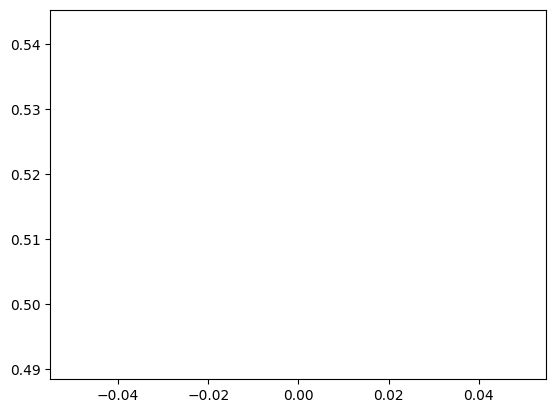

In [60]:
plt.plot(lossi)

No more hockey stick shaped loss. No mighty gains in the beginning!

In [61]:
split_loss('train')
split_loss('val')

train 3.172987937927246
val 3.1684372425079346


The performance has improved a bit, since the few thousand iterations that the models wasted to squash randomly initialized weights are now better spent on the actual training

In [62]:
g = torch.Generator().manual_seed(10)

for _ in range(20):

  out = []
  context = [0]*block_size

  while True:
    emb = C[torch.tensor([context])]
    h0 = emb.view(1, -1) @ W1 + b1
    h = torch.tanh(h0)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim=1)

    ix = torch.multinomial(probs, 1, generator=g).item()
    context = context[1:] + [ix]

    out.append(itos[ix])

    if ix == 0:
      break
      
  print(''.join(out))

pfp.
ehqz.
eeybwixninotomrwlaecozttdskxqlbbypydbjuejwcfmbzcbkmedqxwurautyocvaeaoxruoiymfhoukthkmtzc.
fgethzbdsppsdm.
asfazbaujhensiztsuzhqmsylqjizwpcusqqbpaaxwlpzqhqraueeghcypcn.
vkdijnkfrbvu.
kmx.
.
jv.
ilap.
wvbrbc.
cahxpfmjfojmgamzydeornutsgna.
evsbsbbxl.
hfmcoiiuffzdodtqnkbpgyzlavchmtqysqywmytqdjxslanmxwbjseqasinuhbxyfuevpnlbtpnazzyzhquuxvvznequayntwkmzibapnrbfos.
rhzjwubtyeqdday.
qudckabxgwvxllrdecslkncswjoawoslecippcrqkeqprikjkahjmu.
abiptitrkaoadtxvkumwoyttxyssfjxagwspuwhps.
vnleflphauxmiudieyysytnwshvdh.
nhxqtihazvbxkjmtoszgwdcxbrultqwmtwipiiekgokwxlmvtjymokrxtzehwjlizoitcokvqlmmxurheehwajahdhlqdfbkmrshfkpowcy.
haioek.


The performance is much better than bigrams and MLP, the names generated are better than both as well, but still meh!

#### Issue 2

Initialization, weights look good for now but 1 issue still remains which pertains to tanh. Tanh can be thought of as a squashing function, which converts any number in (-inf, inf) to [-1, 1]. In order to understand the output of tanh operation on embeddings, weights and biases, let's plot the histogram

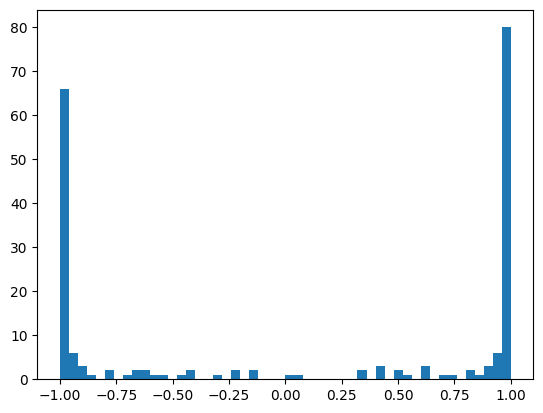

In [63]:
# h is [32, 200], where 200 is dim of hidden layer
# So, flatten h (using view), convert to python list and visualize

plt.hist(h.view(-1).tolist(), bins=50);

Observe that majority of the initial values are either -1 or 1. Let's plot the input to tanh

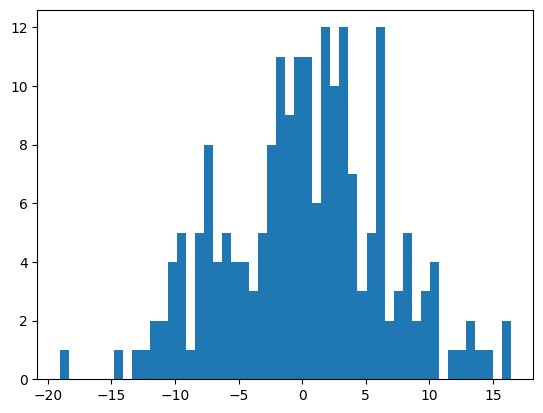

In [64]:
plt.hist(h0.view(-1).tolist(), bins=50);

h0 takes extreme values (between -10 and 10) which makes tanh -1 or 1 many times and this can be an issue in backward prop. Why?

Remember in the autograd notebook, the derivative of tanh = (1 - t**2) * out.grad, where (1 - t**2) is the local derivative and out.grad is the global derivative (from the chain rule). If t is -1 or 1, then first term becomes zero and hence the entire derivative becomes zero. This can result in low learning of the neuron. It can also happen that the entire weight and bias row for the particular are initialized such that the output of the neuron is zero. Such a neuron can be called as a 'Dead Neuron'

Below plot shows how many values in h are non-zero (White pixel means zero and black means non-zero). We would ideally want as many blacks as possible. In case when the entire column in white, it means a dead neuron

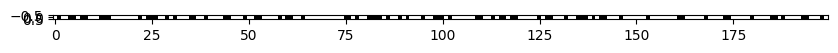

In [65]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In order to reduce the values of h0 and h, we can use similar approach of multiplying the weights and biases by a small number

In [66]:
n_embd = 10
n_hidden = 200

# First let re-initialize the params
g = torch.Generator().manual_seed(10)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print('Total trainable parameters: ', sum(p.nelement() for p in parameters))

# Make sure all the parameters support gradient and updates
for p in parameters:
  p.requires_grad = True

batch_size = 32
max_steps = 200000
lossi = []


for k in range(max_steps):

  # Minibatch index
  ix = torch.randint(0, X_train.shape[0], (batch_size,))


  # Forward Pass
  emb = C[X_train[ix]] # Shape -> (32, 3, 2)
  h0 = emb.view(-1, n_embd * block_size) @ W1 + b1
  h = torch.tanh(h0)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix]) # Need to update target dataset as well

  if k%10000 == 0:
    print(f'Epoch {k} -> Loss = {loss.item()} ')

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Gradient Update
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.log10().item())

  break

Total trainable parameters:  11897
Epoch 0 -> Loss = 3.284036159515381 


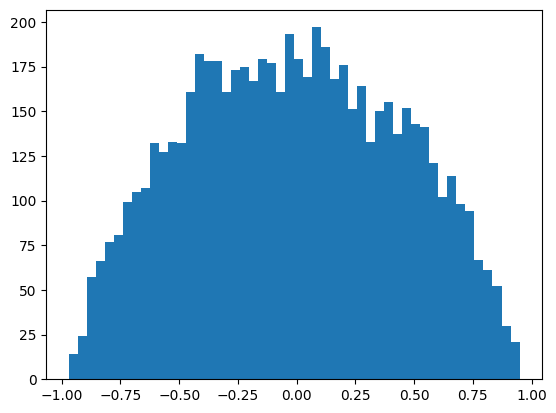

In [67]:
plt.hist(h.view(-1).tolist(), bins=50);

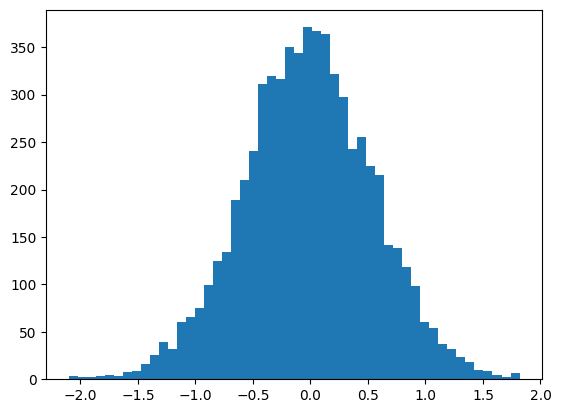

In [68]:
plt.hist(h0.view(-1).tolist(), bins=50);

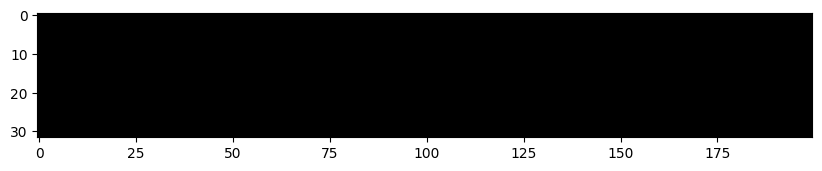

In [69]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Note the following - 

1. Much better distribution of tanh output. Takes many values in [-1,1] and this has primarily to do with the values in graph 2, where h0 takes values between [-2, 2]
2. Notice the entire plot of values > 0.99 is black, which means all the gradients of the neuron are non-zero 

A lot of the numbers used to scale weights and biases are 'magic numbers', hard-coded and based on trial-error approach. In order to come up with a better way to choose these numbers, or precisely, how to initialize the weights and biases, refer Kaiming Initialization paper [here](https://arxiv.org/abs/1502.01852)

The paper talks about the gain that needs to applied when using a particular non-linearity to better initialize the weights and biases. 

Due to advances in techniques like normalization layers (BatchNorm, LayerNorm) and optimizers (RMSProp, ADAM), the neural networks are becoming less sensitive to such issues